In [104]:
from glob import glob
from PIL import Image

import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import skimage
from skimage.transform import rescale, resize
from dlup.data.dataset import TiledROIsSlideImageDataset, SlideImage
from dlup.background import get_mask, entropy_masker

In [26]:
f = h5py.File("/home/sdejong/pmchhg/lightning_logs/version_2418282/output/test/PMC_HHG_36_Hersenen_I-05_5x5_200slow_output.hdf5")

# Unpack hdf5.
data = {}
for k in f.keys():
    try:
        data[k] = f[k][()].decode()
    except (UnicodeDecodeError, AttributeError):
        data[k] = f[k][()]
print(data)


{'attention': array([0.00226613, 0.00226638, 0.00226594, 0.00226847, 0.00226754,
       0.00226699, 0.00226699, 0.00226841, 0.00226712, 0.0022688 ,
       0.00226827, 0.0022709 , 0.00226705, 0.00226769, 0.00226893,
       0.00226807, 0.00226739, 0.00226794, 0.00226556, 0.00226634,
       0.00226738, 0.00226553, 0.00226695, 0.00226758, 0.00226868,
       0.00226646, 0.00226629, 0.00226709, 0.00226705, 0.00226829,
       0.00226812, 0.0022694 , 0.00226784, 0.00226557, 0.00226676,
       0.00226747, 0.00226852, 0.0022695 , 0.00226753, 0.00226644,
       0.00226783, 0.0022664 , 0.00226609, 0.00226782, 0.00226717,
       0.00226675, 0.00226569, 0.0022659 , 0.00226793, 0.00226706,
       0.00226986, 0.0022652 , 0.00226669, 0.00226646, 0.00226547,
       0.0022669 , 0.00226899, 0.00226944, 0.00226654, 0.00226598,
       0.00226719, 0.00226757, 0.0022678 , 0.00226543, 0.00226673,
       0.00226644, 0.00226829, 0.00226701, 0.00227066, 0.00227287,
       0.00226774, 0.00226638, 0.00226758, 0.002

In [28]:
path = glob("../../images-tif/*PMC_HHG_36_Hersenen_I-05_5x5_200slow*")[0]
img_arr = np.array(Image.open(path))
img = SlideImage.from_file_path(path)
mask = get_mask(img, entropy_masker)
dataset = TiledROIsSlideImageDataset.from_standard_tiling(
    path=path,
    mpp=0.2,
    tile_size=(224, 224),
    tile_overlap=(0, 0),
    tile_mode="skip",
    mask=mask,
)

/home/sdejong/.conda/envs/pmchhg/lib/python3.10/site-packages/dlup/background.py:334: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  mask = mask_func(np.asarray(slide.get_thumbnail(size=(size, size))))


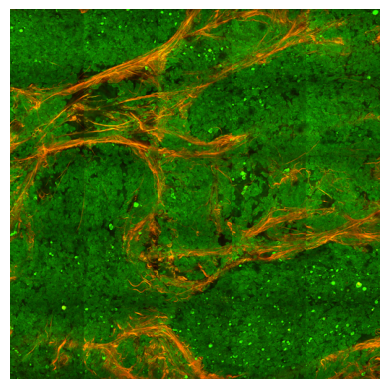

In [32]:
plt.imshow(img.get_thumbnail())
plt.axis("off")
plt.show()

In [30]:
X = data["tile_x"]
Y = data["tile_y"]
A = data["attention"]
T = data["tile_region_index"]
A_norm = (A - np.min(A)) / (np.max(A) - np.min(A))

Xu = np.unique(X)
Yu = np.unique(Y)

A_img = np.zeros((Yu.size, Xu.size))
for i in range(X.size):
    A_img[np.where(Yu == Y[i]), np.where(Xu == X[i])] = A_norm[i]

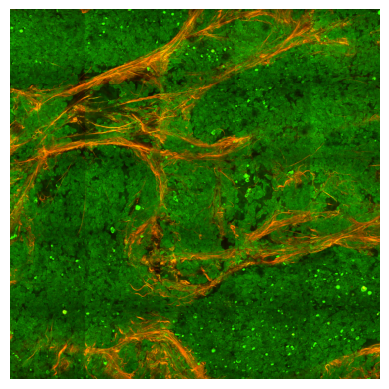

In [31]:
scaling = img.get_scaling(mpp=0.2)
crop = np.subtract(img.size, np.mod(img.size, (224, 224)))  # Crop, because of skip policy with tile making.
img_scaled_cropped = np.array(img.get_thumbnail(img.size))[:crop[1], :crop[0], :]
plt.imshow(img_scaled_cropped)
plt.axis("off")
plt.show()

In [49]:
A_img_resized = resize(A_img, img_scaled_cropped.shape, order=0)  # order=0 means nearest neighbours. newaxis so it can be concatenated.
A_img_weighted = img_scaled_cropped * A_img_resized
A_img_weighted = (A_img_weighted - np.min(A_img_weighted)) / (np.max(A_img_weighted) - np.min(A_img_weighted))
A_img_weighted.shape

(4928, 4928, 3)

In [50]:
skimage.io.imsave(f"outputs/6/{data['case_id']}_{data['img_id']}-attention.png", A_img_weighted)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


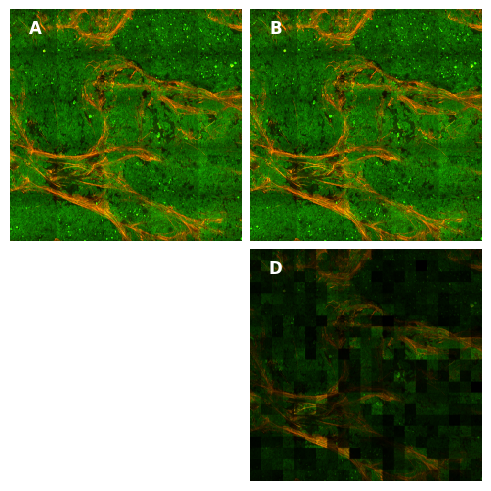

In [129]:
fig, axs = plt.subplot_mosaic([["A", "B"], ["C", "D"]], layout="compressed")

for label, ax in axs.items():
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.05, 0.95, label, transform=ax.transAxes + trans,
            fontsize="large", fontweight="heavy", va="center", ha="center", color="white")

    ax.axis("off")

# Original image, cropped to maximum tile region.
axs["A"].imshow(img_scaled_cropped[::-1])

# Tiles used.
for tile in dataset:
    coords = np.array(tile["coordinates"])
    extent = tuple(np.array((coords[0], coords[0] + 224, coords[1], coords[1]+224)).astype(int))
    axs["B"].imshow(tile["image"], extent=extent, origin="lower")
    axs["B"].set_xlim(0, img_scaled_cropped.shape[0])
    axs["B"].set_ylim(0, img_scaled_cropped.shape[1])

# TODO: Pathologist focus

# Attention weighted image
axs["D"].imshow(A_img_weighted[::-1])

fig.savefig(f"outputs/6/{data['case_id']}_{data['img_id']}-summary.png", bbox_inches="tight", dpi=300)

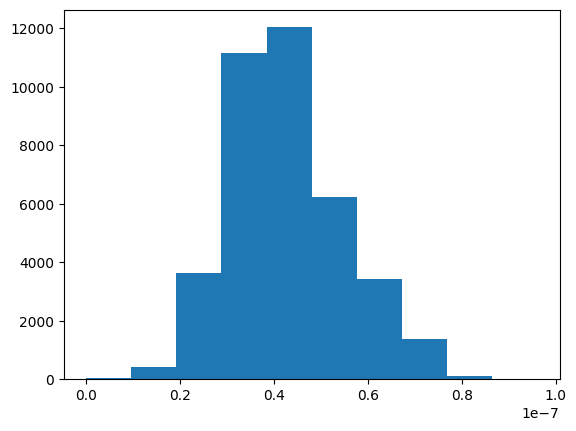

In [48]:
plt.hist(A_norm)
plt.show()